# Simulate the feedforward network including ISP!
Current Based (CuBa) synapses

In [1]:
import numpy as onp
from jax import numpy as np
from jax import random, vmap, jit, value_and_grad
from jax.lax import scan, clamp
from jax.ops import index_min, index_update
from jax.numpy import clip

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("colorblind")
sns.set_context("poster")

In [2]:
# Parameters


Multiple neurons

In [3]:
def make_exc_weights(Ne = 100):
    ge = 140 # pS
    K = np.arange(1, 9)
    P = 5
    Wgroups = 0.3 + 1.1 / (1 + (K - P)**4)
    W = np.repeat(Wgroups, Ne)
    eps = onp.random.uniform(0, 0.1, size=W.shape[0])
    W += eps
    return Wgroups, W / 10

Wgroups, We = make_exc_weights()

In [4]:
from jax.experimental.optimizers import adam

In [5]:
slope = 1
import jax
@jax.custom_transforms
def spiking_fn(x):
    return np.where(x>0, 1.0, 0.0)

jax.defvjp(spiking_fn, lambda g, ans, x: g / (slope * np.abs(x) + 1.0)**2)

In [6]:
def step(params, states, xt):
    """
    params contains only Wi for now
    xt: exc. and inh spikes
    """
    # Grab paraams
    p = {'vrest': 0, 'vth': 1, 'tref': 5.0,
         'te': 5.0, 'ti': 10.0, 'tau': 20.0, 
        't_stdp' : 20.0, 'rho': 2.0 * 10**(-3), 
        'We': We}
    dt = 1.0
    
    v, spike, tspike, ge, gi, xe, xi, t, E, I = states # ((1, ); (1,), (Ne, ); (Ni, ))
    spike = spiking_fn(v - p['vth'])#np.where(v >= p['vth'], 1.0, 0.0)
    tspike = np.where(spike==1.0, t, tspike)
    
    ge = (1 - dt / p['te']) * ge + xt[0]
    gi = (1 - dt / p['ti']) * gi + xt[1] # TO DO: Ni< Ne
    xe = (1 - dt / p['t_stdp']) * xe + spike # Postsynaptic trace
    xi = (1 - dt / p['t_stdp']) * xi + xt[1] # Presynaptic trace
    E = np.dot(ge, p['We']) 
    I = np.dot(-gi, np.abs(params['Wi']))
    dvdt = (p['vrest'] - v) + E + I + 1
    v = np.where(t - tspike <= p['tref'], p['vrest'], v + dt / p['tau'] * dvdt)
    
    states =  v, spike, tspike, ge, gi, xe, xi,  t+1, E, I
    return states, states

def update_params(step, get_params, opt_state, opt_update, x):
    params = get_params(opt_state)
    
    def loss_fn(params, x):
        states = lif_neuron(params, x)
        xe = states[5]
        alpha = 2 * 2.0 * 10**(-3) * 20.0 
        return np.mean((xe - alpha)**2)
    
    losses, grads = value_and_grad(loss_fn)(params, x)
    return losses, opt_update(step, grads, opt_state)

update_params_jit = jit(update_params, (1, 3))
def gen_init_states():
    v = np.ones((1, )) * -60.0
    spike = np.zeros((1, )) * 1.0
    tspike = np.ones((1,)) * -np.inf
    ge = np.zeros((Ne * n_groups, )) * 1.0
    gi = np.zeros((Ne * n_groups, )) * 1.0
    xe = np.zeros((1, )) * 1.0
    xi = np.zeros((Ne * n_groups, )) * 1.0
    t = 0.0
    E, I = 0.0, 0.0
    return v, spike, tspike, ge, gi, xe, xi, t, E, I 

def lif_neuron(params, x):
    init_states = gen_init_states()
    _, states = scan(lambda s, x: step(params, s, x), init_states, x)
    return states

lif_neuron_jit = jit(lif_neuron, (0, ))

In [7]:
Ne = 100
time_steps = 300
n_groups = 8
Wgroups, We = make_exc_weights(Ne)
key = random.PRNGKey(onp.random.randint(1e6))
Wi = random.normal(key, shape = (Ne * n_groups,)) * 1 / np.sqrt(Ne * n_groups)

Add weights. 

# Use generated rates

In [8]:
import sys
sys.path.append("../src/")
from data_utils import ou_process_jit
import data_utils

# Multiple runs

In [9]:
def make_data(key, time_steps = 1000):
    keys = random.split(key, n_groups+1)[1:]
    input_params = {'mu': -2, 'tau': 20.0, 'sigma': 1.0} # dt in ms
    xs, ys, spikes = data_utils.ou_process_jit(input_params, time_steps, Ne * 2, keys) # Exc and inh.
    xe = spikes[:,:Ne].reshape((-1, time_steps)).T
    xi = spikes[:,Ne:].reshape((-1, time_steps)).T
    x = np.concatenate((xe[:,None], xi[:,None]), 1) #(time steps, 2, neurons)
    return x

In [10]:
def split_keys(key, n_keys):
    new_keys = random.split(key, n_keys+1)
    return (k for k in new_keys[1:])

In [21]:
from jax.experimental.optimizers import adam
opt_init, opt_update, get_params = adam(1e-3)
params = {'Wi':  random.normal(key, shape = (Ne * n_groups,)) * 0.1 / np.sqrt(Ne * n_groups)}
opt_state = opt_init(params)

0 1.0024444 -0.81 49.0
10 1.1223838 -0.84 51.0
20 0.52722496 -0.78999996 29.0
30 0.2934064 -0.81 20.0
40 0.18845442 -0.78999996 12.0
50 0.02052125 -0.9 2.0
60 0.030073574 -0.84 3.0
70 0.013456409 -0.85999995 1.0
80 0.020512821 -0.9 2.0
90 0.013456408 -0.89 1.0
100 0.027584761 -0.87 3.0
110 0.054688115 -0.85999995 6.0
120 0.058316935 -0.91999996 6.0
130 0.020512888 -0.88 2.0
140 0.07245346 -0.84999996 7.0
150 0.047665317 -0.90999997 5.0
160 0.035005443 -0.90999997 3.0
170 0.042065587 -0.89 4.0
180 0.035228055 -0.9 4.0
190 0.041942295 -0.93 5.0


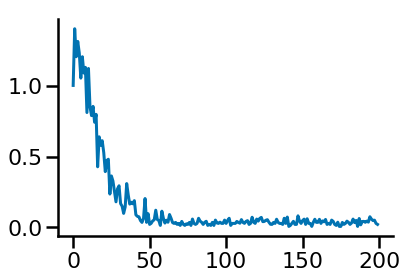

In [22]:
n_trials = 200
seed = onp.random.randint(1e6)
key = random.PRNGKey(seed)
keys = split_keys(key, n_trials+1)

loss_hist = []
alpha = 2 * 5.0 * 10**(-3) * 20.0 
for trial in range(n_trials):
    x = make_data(next(keys))
    l, opt_state = update_params_jit(trial, get_params, opt_state, opt_update, x)
    if trial % 10 == 0: 
        params = get_params(opt_state)
        v, spike, tspike, ge, gi, xe, xi, t, E, I = lif_neuron_jit(params, x)
        rho = onp.corrcoef(E, I)[0,1]
        print(trial, l, np.round(rho, 2),  spike.sum())
    loss_hist.append(l)
plt.plot(loss_hist)
sns.despine()

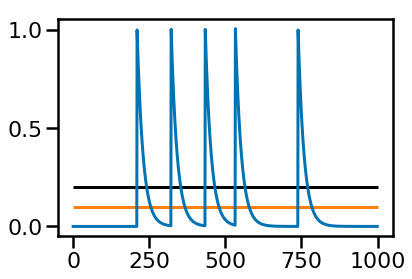

In [23]:
plt.plot(xe)
plt.hlines(xe.mean(), 0, 1000, color='tab:orange')
plt.hlines(alpha, 0, 1000)

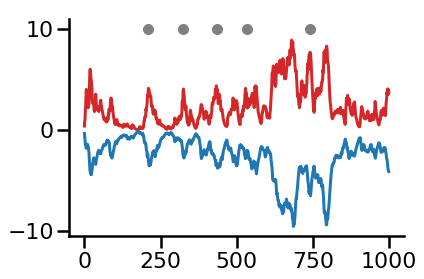

In [24]:
params = get_params(opt_state)
Wi = np.abs(params['Wi'])
plt.plot(np.dot(ge, We), color = 'tab:red' )
plt.plot(np.dot(-gi, Wi), color='tab:blue') 
spike_times = np.where(spike[:,0])[0]
plt.plot(spike_times, np.ones((len(spike_times),)) * 10, 'o', color='gray', markersize=10)
sns.despine()

In [25]:
x = make_data(key,10000)
states = lif_neuron_jit(params, x)
v, spike, tspike, ge, gi, xe, xi, t, E, I  = states

 Rate:  5.4


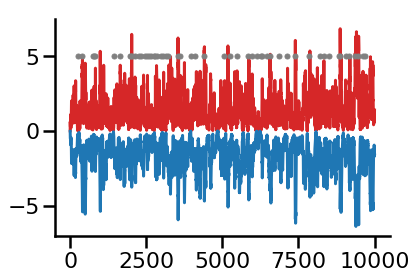

In [26]:
plt.plot(np.dot(ge, We), color = 'tab:red' )
plt.plot(np.dot(-gi, np.abs(Wi)), color='tab:blue') 
spike_times = np.where(spike[:,0])[0]
plt.plot(spike_times, np.ones((len(spike_times),)) * 5, 'o', color='gray', markersize=5)
sns.despine()
print(" Rate: ", spike.sum() / 10)

-0.9062263959001936

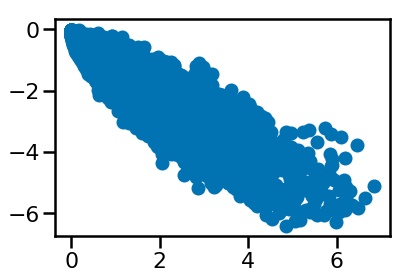

In [27]:
E = np.dot(ge, We)
I = np.dot(gi, np.abs(Wi)) *-1
plt.scatter(E, I)
onp.corrcoef(E, I)[0,1]

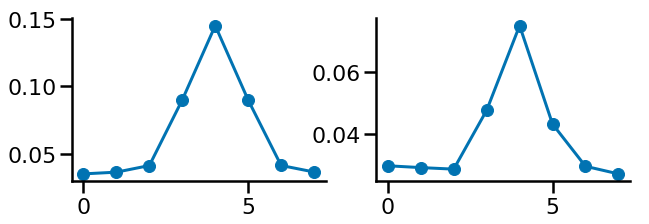

In [28]:
We_mean = []
for n in range(n_groups):
    We_mean.append(We[n*100:(n+1)*100].mean())
f, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(We_mean,'o-')
Wi_mean = []
for n in range(n_groups):
    Wi_mean.append(np.abs(Wi)[n*100:(n+1)*100].mean())
ax[1].plot(Wi_mean,'o-')
sns.despine()